# Comparing Optimal Transport Methods for Nested Distance Computation

The goal of this notebook is to compare the performance of different optimal transport methods in computing the nested distance for an example of a stochastic tree. We evaluate the following methods:

1. **Algorithm 1:** Linear Programming on Tree Structure  
   *From:* **Nested Sinkhorn Divergence To Compute The Nested Distance**  
   *Alois Pichler & Michael Weinhardt*

2. **Algorithm 2:** POT Package to Solve the Inner OT Problem
   *From:* **Nested Sinkhorn Divergence To Compute The Nested Distance**  
   *Alois Pichler & Michael Weinhardt*

3. **Algorithm 3:** Sinkhorn Iteration on Trees  
   *From:* **Nested Sinkhorn Divergence To Compute The Nested Distance**  
   *Alois Pichler & Michael Weinhardt*

4. **Algorithm 4:** Linear Programming on Weighted Sample Paths  
   *From:* **Computational Methods for Adapted Optimal Transport**  
   *Stephan Eckstein and Gudmund Pammer*

In [50]:
import time

import os
import sys

aot_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AOT_numerics')
trees_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees')
awd_trees_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AWD_trees')

# Add paths to sys.path
for path in [aot_path, awd_trees_path, trees_path]:
    if path not in sys.path:
        sys.path.append(path)

# Add it to sys.path if not already present
if trees_path not in sys.path:
    sys.path.append(trees_path)
from Tree_Node import *
from TreeAnalysis import *
from TreeVisualization import *
from Save_Load_trees import *
from Tree_AWD_utilities import *

from Nested_Dist_Algo import compute_nested_distance
from Gurobi_AOT import *
from mainfunctions import *
from measure import *
from normal_ot import *
from FVI_bench import *

import numpy as np

In [51]:
# Load the trees
tree_1_root = load_tree('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees/Data_trees_exemple', 'tree_1.pkl')
tree_2_root = load_tree('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees/Data_trees_exemple', 'tree_2.pkl')

Tree successfully loaded from /Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees/Data_trees_exemple/tree_1.pkl
Tree successfully loaded from /Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees/Data_trees_exemple/tree_2.pkl


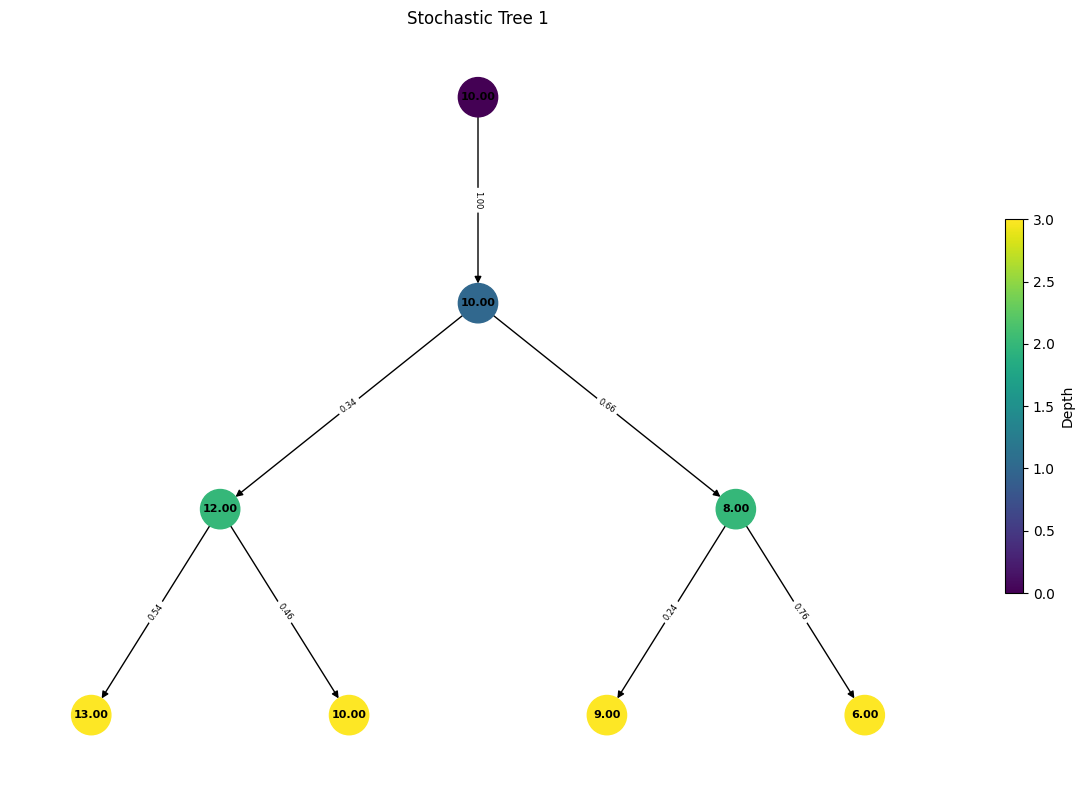

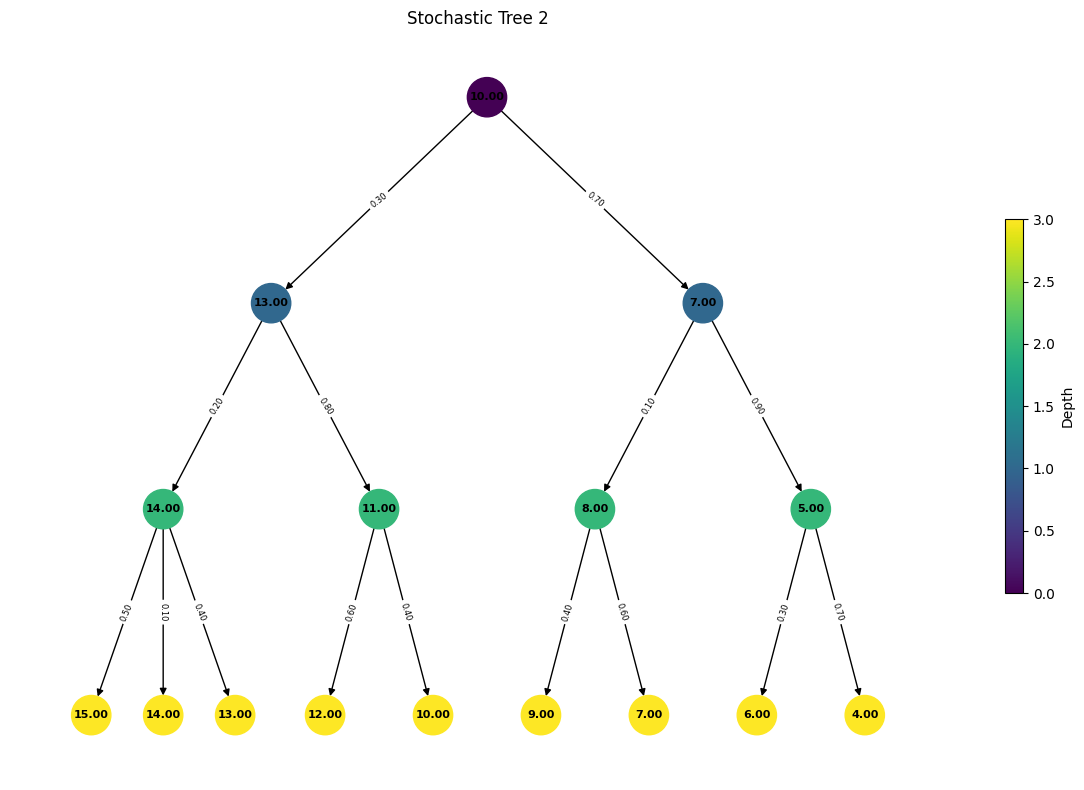

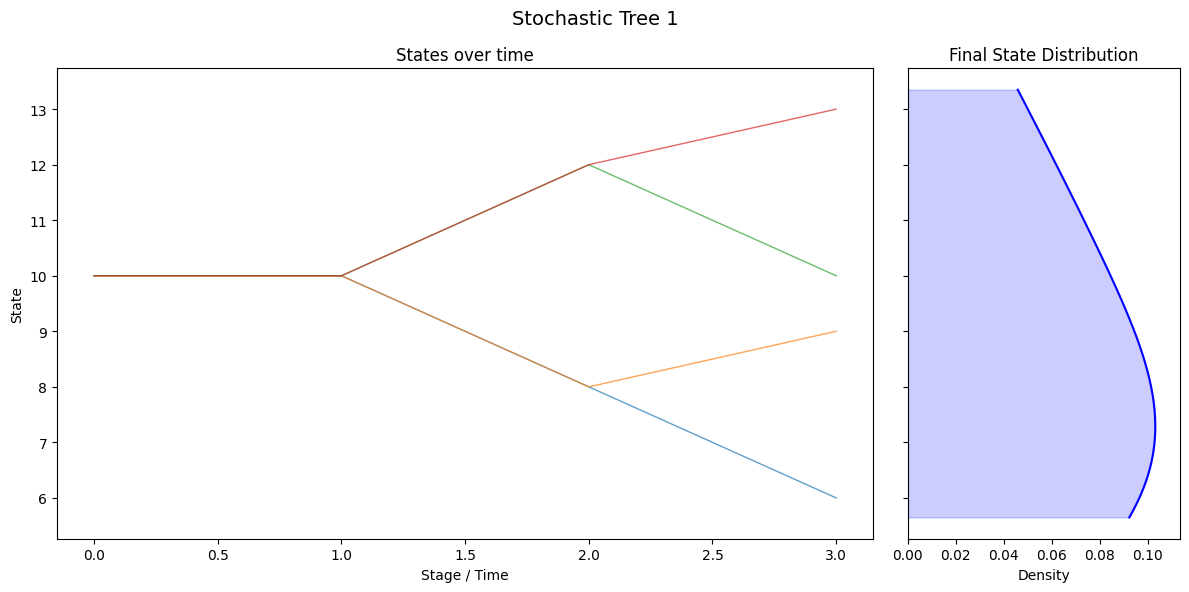

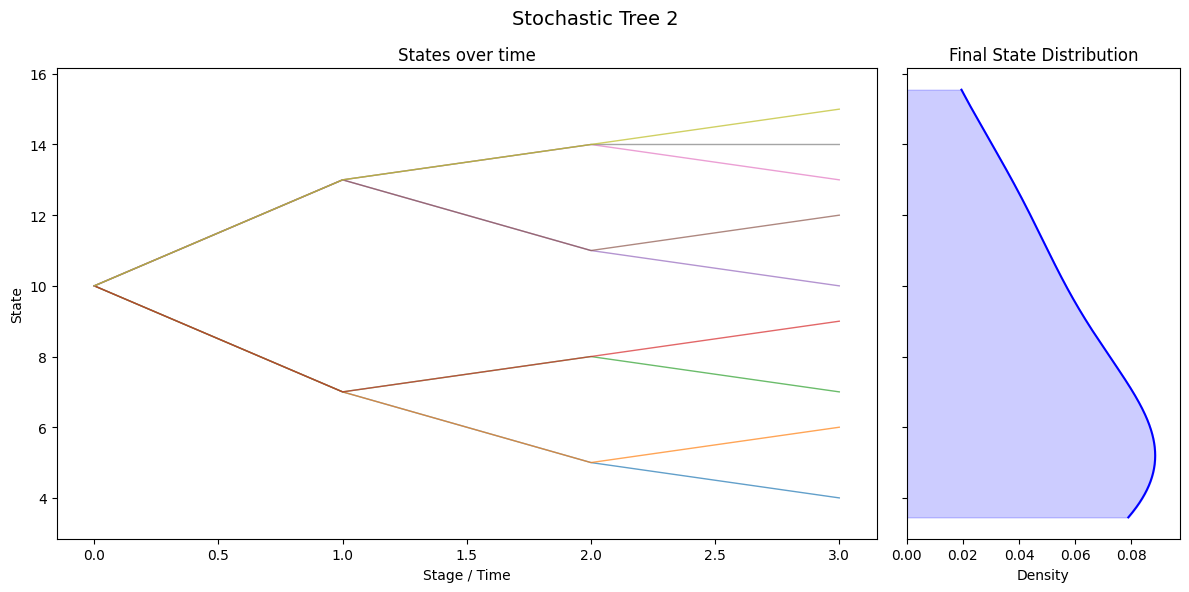


Tree 1 (Path and Weight Format):
Paths:
[[10 10 12 13]
 [10 10 12 10]
 [10 10  8  9]
 [10 10  8  6]]
Weights:
[0.1836 0.1564 0.1584 0.5016]

Tree 2 (Path and Weight Format):
Paths:
[[10 13 14 15]
 [10 13 14 14]
 [10 13 14 13]
 [10 13 11 12]
 [10 13 11 10]
 [10  7  8  9]
 [10  7  8  7]
 [10  7  5  6]
 [10  7  5  4]]
Weights:
[0.03  0.006 0.024 0.144 0.096 0.028 0.042 0.189 0.441]


In [52]:
# Determine the maximum depth of the trees
max_depth = get_depth(tree_1_root)

visualize_tree(tree_1_root, title="Stochastic Tree 1")
visualize_tree(tree_2_root, title="Stochastic Tree 2")

visualize_big_tree(tree_1_root, fig_size=(12,6), title="Stochastic Tree 1")
visualize_big_tree(tree_2_root, fig_size=(12,6), title="Stochastic Tree 2")


formatted_tree_1 = get_sample_paths(tree_1_root)
formatted_tree_2 = get_sample_paths(tree_2_root)

display_tree_data(formatted_tree_1, "Tree 1")
display_tree_data(formatted_tree_2, "Tree 2")

In [53]:
def print_results(distance, prob_matrix, elapsed_time):
    """Prints the nested distance, probability matrix, and computation time in a formatted way."""
    print(f"Nested Distance: {distance}\n")
    print(f"Final Probability Matrix:")
    for row in prob_matrix:
        print(" | ".join(f"{value:.5f}" for value in row))
    print(f"\nComputation Time: {elapsed_time:.4f} seconds\n")
    print("-" * 50 + "\n")

### Linear Program

In [54]:
start_time = time()

distance, final_prob_matrix = compute_nested_distance(
    tree_1_root, tree_2_root, max_depth, method="solver_lp", return_matrix=True, lambda_reg=0
)

end_time = time()
elapsed_time = end_time - start_time

print_results(distance, final_prob_matrix, elapsed_time)

Nested Distance: 10.08776

Final Probability Matrix:
0.00240 | 0.00600 | 0.02400 | 0.02268 | 0.00000 | 0.00000 | 0.03780 | 0.00000 | 0.09072
0.02760 | 0.00000 | 0.00000 | 0.00252 | 0.01680 | 0.02800 | 0.00420 | 0.05040 | 0.02688
0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.04752 | 0.00000 | 0.00000 | 0.00000 | 0.11088
0.00000 | 0.00000 | 0.00000 | 0.11880 | 0.03168 | 0.00000 | 0.00000 | 0.13860 | 0.21252

Computation Time: 0.0217 seconds

--------------------------------------------------



### POT Package

In [55]:
start_time = time()

distance, final_prob_matrix = compute_nested_distance(
    tree_1_root, tree_2_root, max_depth, method="solver_pot", return_matrix=True, lambda_reg=0
)

end_time = time()
elapsed_time = end_time - start_time

print_results(distance, final_prob_matrix, elapsed_time)

Nested Distance: 10.087759999999998

Final Probability Matrix:
0.03000 | 0.00240 | 0.00000 | 0.02268 | 0.00000 | 0.00000 | 0.03780 | 0.00000 | 0.09072
0.00000 | 0.00360 | 0.02400 | 0.00252 | 0.01680 | 0.02800 | 0.00420 | 0.05040 | 0.02688
0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.04752 | 0.00000 | 0.00000 | 0.00000 | 0.11088
0.00000 | 0.00000 | 0.00000 | 0.11880 | 0.03168 | 0.00000 | 0.00000 | 0.13860 | 0.21252

Computation Time: 0.0062 seconds

--------------------------------------------------



In [56]:
start_time = time()

distance, final_prob_matrix = compute_nested_distance(
    tree_1_root, tree_2_root, max_depth, method="solver_lp_pot", return_matrix=True, lambda_reg=0
)

end_time = time()
elapsed_time = end_time - start_time

print_results(distance, final_prob_matrix, elapsed_time)

Nested Distance: 10.087759999999998

Final Probability Matrix:
0.03000 | 0.00240 | 0.00000 | 0.02268 | 0.00000 | 0.00000 | 0.03780 | 0.00000 | 0.09072
0.00000 | 0.00360 | 0.02400 | 0.00252 | 0.01680 | 0.02800 | 0.00420 | 0.05040 | 0.02688
0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.04752 | 0.00000 | 0.00000 | 0.00000 | 0.11088
0.00000 | 0.00000 | 0.00000 | 0.11880 | 0.03168 | 0.00000 | 0.00000 | 0.13860 | 0.21252

Computation Time: 0.0061 seconds

--------------------------------------------------



### Sinkhorn Algorithm with Regularization

In [57]:
# Start timing the Sinkhorn with regularization computation
start_time = time()

# Compute nested distance using Sinkhorn iteration with regularization
distance_sinkhorn_reg, final_prob_matrix_sinkhorn_reg = compute_nested_distance(
    tree_1_root, tree_2_root, max_depth, method="Sinkhorn", return_matrix=True, lambda_reg=10
)

# End timing
end_time = time()
elapsed_time_sinkhorn_reg = end_time - start_time

print_results(distance_sinkhorn_reg, final_prob_matrix_sinkhorn_reg, elapsed_time_sinkhorn_reg)

Nested Distance: 10.087725888974695

Final Probability Matrix:
0.01620 | 0.00324 | 0.01296 | 0.02268 | 0.00000 | 0.01512 | 0.02268 | 0.02722 | 0.06350
0.01380 | 0.00276 | 0.01104 | 0.00252 | 0.01680 | 0.01288 | 0.01932 | 0.02318 | 0.05410
0.00000 | 0.00000 | 0.00000 | 0.02851 | 0.01901 | 0.00000 | 0.00000 | 0.03326 | 0.07762
0.00000 | 0.00000 | 0.00000 | 0.09029 | 0.06019 | 0.00000 | 0.00000 | 0.10534 | 0.24579

Computation Time: 0.0733 seconds

--------------------------------------------------



In [58]:
#Slow and not accurate but can be optimized I think

start_time = time()

distance, final_prob_matrix = compute_nested_distance(
    tree_1_root, tree_2_root, max_depth, method="solver_jax", return_matrix=True, lambda_reg=10
)

end_time = time()
elapsed_time = end_time - start_time

print_results(distance, final_prob_matrix, elapsed_time)

Nested Distance: 10.205149859581988

Final Probability Matrix:
0.01123 | 0.00225 | 0.00898 | 0.03203 | 0.00059 | 0.00930 | 0.01395 | 0.03158 | 0.07369
0.00957 | 0.00191 | 0.00765 | 0.00422 | 0.02357 | 0.00792 | 0.01188 | 0.02690 | 0.06277
0.00221 | 0.00044 | 0.00177 | 0.02586 | 0.01724 | 0.00644 | 0.00003 | 0.03132 | 0.07309
0.00700 | 0.00140 | 0.00560 | 0.08189 | 0.05459 | 0.00434 | 0.01613 | 0.09919 | 0.23145

Computation Time: 3.6596 seconds

--------------------------------------------------



### Computing Nested Distance Using Gurobi (Linear Programming)

In [62]:
def cost_function(x, y):
    """Cost function: L1 distance."""
    return np.sum(np.abs(x - y))

start_time = time()

val_gurobi, pi_gurobi = gurobi_bm(
    [formatted_tree_1, formatted_tree_2],
    f=cost_function,
    r_opti=1,
    causal=0,
    anticausal=0,
    outputflag=0
)

end_time = time()
elapsed_time_gurobi = end_time - start_time


print_results(val_gurobi, pi_gurobi, elapsed_time_gurobi)

Nested Distance: 7.031599999999999

Final Probability Matrix:
0.03000 | 0.00600 | 0.02400 | 0.12360 | 0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.00000
0.00000 | 0.00000 | 0.00000 | 0.02040 | 0.09600 | 0.02800 | 0.01200 | 0.00000 | 0.00000
0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.03000 | 0.00000 | 0.12840
0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.18900 | 0.31260

Computation Time: 0.0039 seconds

--------------------------------------------------



## No Idea why the bellow does not work gives back the wasserstein distance not the adapted Wasserstein distance.

In [63]:
# ----- Build the Graph -----
# We assume the columns of new_sample_paths_x and new_sample_paths_y correspond to time steps.

# Compute empirical measures using k-means clustering.
# The empirical_k_means_measure function returns a tuple: (support array, weights).
new_sample_paths_x = formatted_tree_1[0]
new_weights_x = formatted_tree_1[1]
new_sample_paths_y = formatted_tree_2[0]
new_weights_y = formatted_tree_2[1]

print("Empirical Measure for μ (support):", new_sample_paths_x.shape)
print("Empirical Measure for ν (support):", new_sample_paths_y.shape)

T_h = new_sample_paths_x.shape[1]  # Number of time steps in the empirical measure.
g = Graph(T_h)
for t in range(T_h-1):
    g.addEdge(t, t + 1)

# ----- Define the Measure and Support Functions -----
# For a static (non-adapted) measure, we can simply ignore the conditioning.
def mu(node, x_parents):
    # Return the marginal at the given time (node) as a 2D array (support) and the weights.
    # Here, new_sample_paths_x is assumed to be of shape (k, T_h) where k is the number of clusters.
    support = new_sample_paths_x[:, node:node+1]  # Extract column 'node' as a (k,1) array.
    return [support, new_weights_x]

def supp_mu(node_list):
    # Given a list of node indices, return the corresponding columns from new_sample_paths_x.
    if len(node_list) == 0:
        # If there are no nodes, return an empty array with the right number of rows.
        return np.empty((new_sample_paths_x.shape[0], 0))
    return new_sample_paths_x[:, node_list]

def nu(node, x_parents):
    support = new_sample_paths_y[:, node:node+1]
    return [support, new_weights_y]

def supp_nu(node_list):
    if len(node_list) == 0:
        return np.empty((new_sample_paths_y.shape[0], 0))
    return new_sample_paths_y[:, node_list]

# ----- Define the Squared Cost Function -----
# This cost function computes the squared difference.
def cost(x, y):
    return abs(x[0] - y[0])

# Build the cost list for solve_dynamic.
# For each time node t, we associate a cost function that depends only on that node.
cost_list = [[[t], cost] for t in range(T_h)]

# ----- Solve the Adapted Optimal Transport Problem -----
start_time = time()
# solve_dynamic returns a list of optimal values and additional coupling information.
out_vals, opt_info = solve_dynamic(cost_list, mu, nu, supp_mu, supp_nu, g, outputflag=0, method='pot')
elapsed_time = time() - start_time

# ----- Display the Results -----
print("AOT values:", out_vals)
print("Elapsed time (seconds):", elapsed_time)

Empirical Measure for μ (support): (4, 4)
Empirical Measure for ν (support): (9, 4)
AOT values: [7.0316]
Elapsed time (seconds): 0.18996930122375488


In [64]:

EPS = 0.1

def cost_f_scalar_2(x, y):
    return np.abs(x-y)

# Sinkhorn
new_sample_paths_x = formatted_tree_1[0]
new_weights_x = formatted_tree_1[1]
new_sample_paths_y = formatted_tree_2[0]
new_weights_y = formatted_tree_2[1]

print("Empirical Measure for μ (support):", new_sample_paths_x.shape)
print("Empirical Measure for ν (support):", new_sample_paths_y.shape)

T_h = new_sample_paths_x.shape[1]  # Number of time steps in the empirical measure.
g = Graph(T_h)
for t in range(T_h-1):
    g.addEdge(t, t + 1)

# ----- Define the Measure and Support Functions -----
# For a static (non-adapted) measure, we can simply ignore the conditioning.
def mu(node, x_parents):
    # Return the marginal at the given time (node) as a 2D array (support) and the weights.
    # Here, new_sample_paths_x is assumed to be of shape (k, T_h) where k is the number of clusters.
    support = new_sample_paths_x[:, node:node+1]  # Extract column 'node' as a (k,1) array.
    return [support, new_weights_x]

def supp_mu(node_list):
    # Given a list of node indices, return the corresponding columns from new_sample_paths_x.
    if len(node_list) == 0:
        # If there are no nodes, return an empty array with the right number of rows.
        return np.empty((new_sample_paths_x.shape[0], 0))
    return new_sample_paths_x[:, node_list]

def nu(node, x_parents):
    support = new_sample_paths_y[:, node:node+1]
    return [support, new_weights_y]

def supp_nu(node_list):
    if len(node_list) == 0:
        return np.empty((new_sample_paths_y.shape[0], 0))
    return new_sample_paths_y[:, node_list]


x_list, mu_list = get_meas_for_sinkhorn(mu, supp_mu, T_h)
y_list, nu_list = get_meas_for_sinkhorn(nu, supp_nu, T_h)
ind_tot = get_full_index_markov(nu_list)
ind_next_l = get_start_next_indices(ind_tot)
nu_joint_prob = get_joint_prob(nu_list, ind_tot, T_h-2)
cost_mats_2 = []
for t in range(T_h):
    cmh_2 = np.zeros([len(x_list[t]), len(y_list[t])], dtype=np.float64)
    # if t == T:
    for i in range(len(x_list[t])):
        for j in range(len(y_list[t])):
            cmh_2[i, j] = np.exp(-1 / EPS * cost_f_scalar_2(x_list[t][i], y_list[t][j]))
    cost_mats_2.append(cmh_2)

n_list = [len(x_list[i]) for i in range(T_h)]
m_list = [len(y_list[i]) for i in range(T_h)]

print('n_list', n_list)
print('m_list', m_list)

start_time_bw = time()
val_sink_2 = sinkhorn_bicausal_markov(mu_list, nu_list, cost_mats_2, n_list, m_list, eps_stop=10**-4, max_iter=1000,
                                          reshape=True, outputflag=0)


sink_bc_v2 = val_sink_2 * EPS

    
print('Values for Sinkhorn (bicausal), EPS = ' + str(EPS), sink_bc_v2)
elapsed_time_bw = time() - start_time_bw
print("Elapsed time (seconds):", elapsed_time_bw)

Empirical Measure for μ (support): (4, 4)
Empirical Measure for ν (support): (9, 4)
n_list [4, 4, 4, 4]
m_list [9, 9, 9, 9]
Values for Sinkhorn (bicausal), EPS = 0.1 nan
Elapsed time (seconds): 0.03916501998901367


/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AOT_numerics/mainfunctions.py:457: RuntimeWarning: overflow encountered in exp
  return bt/np.exp(cth), cth
/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AOT_numerics/mainfunctions.py:466: RuntimeWarning: divide by zero encountered in divide
  bt = 1. / np.sum(ft * ct * mut, axis=0, keepdims=True)
/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AOT_numerics/mainfunctions.py:440: RuntimeWarning: divide by zero encountered in divide
  at = 1. / np.matmul(ct, (gt*nut).T)
/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AOT_numerics/mainfunctions.py:442: RuntimeWarning: invalid value encountered in divide
  return at/np.exp(cth), cth
/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AOT_numerics/mainfunctions.py:461: RuntimeWarning: invalid value encountered in multiply
  at = 1. / np.sum(gt * ct * nut, axis=1, keepdims=True)


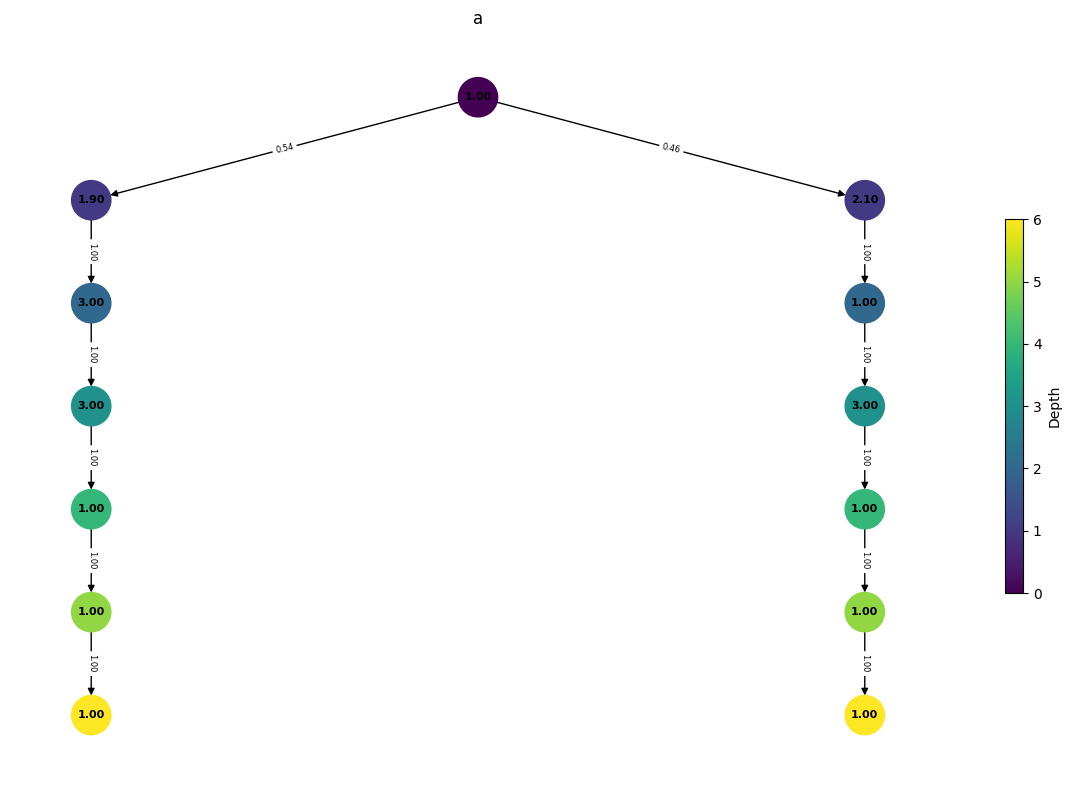

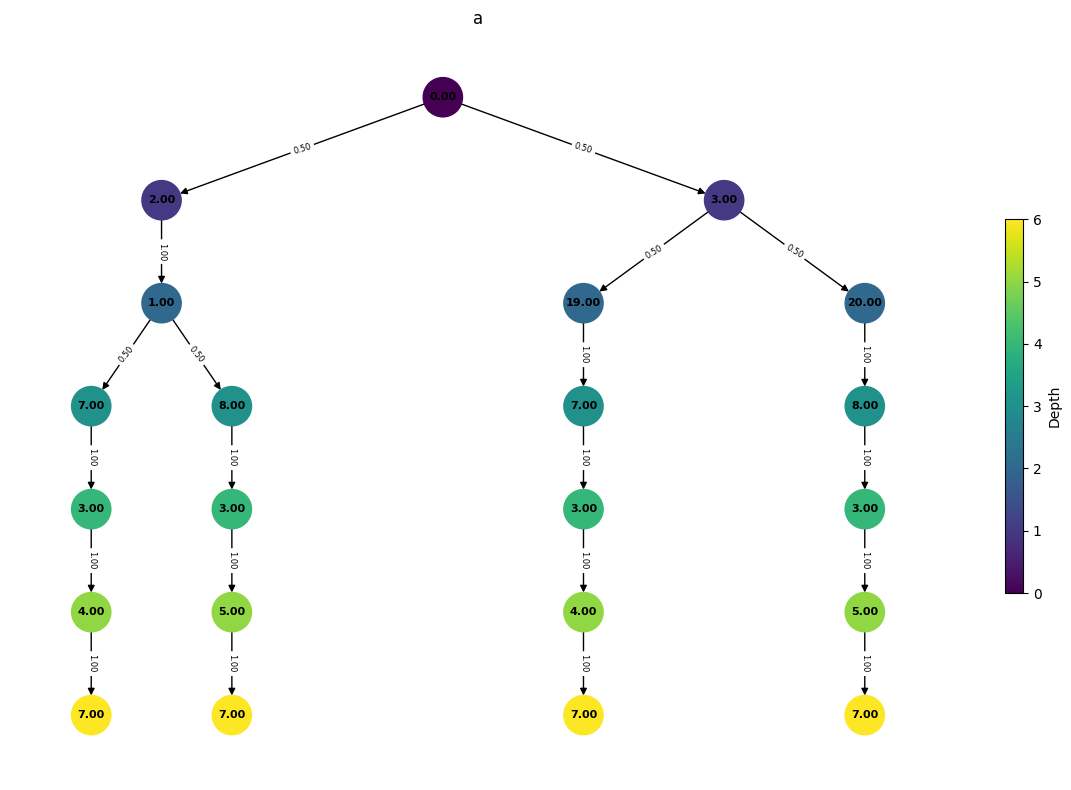

Nested Distance: 25.93

Final Probability Matrix:
0.02000 | 0.02000 | 0.25000 | 0.25000
0.23000 | 0.23000 | 0.00000 | 0.00000

Computation Time: 0.0085 seconds

--------------------------------------------------

25.93


In [83]:
from Build_trees_from_paths import *
tree1_paths = np.array([
    [1,2-0.1,3, 3,1,1,1],
    [1,2+0.1, 1, 3,1,1,1]
])

tree1_weights = np.array([0.1836, 0.1564, 0.1584, 0.5016])

tree2_paths = np.array([
    [0,2,1,7,3,4,7],
    [0,2,1,8,3,5, 7],
    [0,3,19,7,3,4, 7],
    [0,3,20,8,3,5,7]
])

tree2_weights = np.array([0.25,0.25, 0.25, 0.25])

tree1_root = build_tree_from_paths(tree1_paths, tree1_weights)

tree2_root = build_tree_from_paths(tree2_paths, tree2_weights)

visualize_tree(tree1_root, "a")
visualize_tree(tree2_root, "a")

start_time = time()

max_depth = get_depth(tree1_root)

distance, final_prob_matrix = compute_nested_distance(
    tree1_root, tree2_root, max_depth, method="solver_lp_pot", return_matrix=True, lambda_reg=0
)

end_time = time()
elapsed_time = end_time - start_time

print_results(distance, final_prob_matrix, elapsed_time)


def cost_function(x, y):
    """Cost function: L1 distance."""
    return np.sum(np.abs(x - y))


formatted_tree_1 = get_sample_paths(tree1_root)
formatted_tree_2 = get_sample_paths(tree2_root)
start_time = time()

val_gurobi = gurobi_bm(
    [formatted_tree_1, formatted_tree_2],
    f=cost_function,
    r_opti=0,
    causal=0,
    anticausal=0,
    outputflag=0
)

end_time = time()
elapsed_time_gurobi = end_time - start_time


print(val_gurobi)
